#### Import packages


In [13]:
import joblib
import numpy as np
import seaborn as sns
from Bio import SeqIO
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', None)  # show all columns

from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample, shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

#### Load data
Define functions used for loading data.


In [14]:
def read_process_label_file(label_file_path):
    label_table = pd.read_csv(label_file_path, sep='\t', usecols=['pdb_id', 'cath'])[['pdb_id', 'cath']]  # ensure columns in ['pdb_id', 'cath'] order

    chain_id_2_domain_position_2_class_label = []

    # iterate over rows in label_table
    for row in label_table.itertuples(index=False, name='Pandas'):
        pdb_id = row.pdb_id
        cath_content = row.cath
        cath_content = cath_content.split('),(')
        cath_content = [tuple.strip(')(') for tuple in cath_content]  # remove specific leading and trailing characters '(' and ')' in the string
        for tuple in cath_content:
            tuple_content = tuple.split(',')  # tuple example: (2-42:A,420-555:A,2.105.10.10)
            cath_label = tuple_content.pop(-1)  # e.g: 2.105.10.10 (class.architecture.topology.homologous_superfamiliy)
            class_label = int(cath_label[:1])  # extract only the class label
            #class_arch_label = [int(cath_label.split('.')[0]), int(cath_label.split('.')[1])]  # label for class & architecture prediction
            for domain_info in tuple_content:
                chain_name = domain_info.split(':')[1]  # domain_info example: 2-42:A
                chain_id = pdb_id +':' + chain_name
                domain_position = domain_info.split(':')[0]
                chain_id_2_domain_position_2_class_label.append([chain_id, domain_position, class_label])  # add parse result as list to list

    # convert result list to DataFrame
    df_label = pd.DataFrame(chain_id_2_domain_position_2_class_label, columns=['chain_id', 'domain_position', 'class_label'])

    return df_label


def read_combine_seq_file(df_label, seq_file_path):
    seq_dict = SeqIO.to_dict(SeqIO.parse(seq_file_path, 'fasta'))

    chain_id_2_seq_2_class_label = []
    aas = []

    # iterate over rows in df_label
    for row in df_label.itertuples(index=False, name='Pandas'):
        chain_id = row.chain_id
        class_label = row.class_label

        # parse domain position info
        if row.domain_position.startswith('-'):
            domain_position = [row.domain_position[:2], row.domain_position[3:]]  # example domain_position: -3-64 (first-M-based)
        else:
            domain_position = row.domain_position.split('-')  # example domain_position: 2-42 (first-M-based)
        try:
            seq_start = int(domain_position[0])
            seq_end = int(domain_position[1])
        except:
            continue  # there are positions consist of number and letter, e.g. 1S-104S, ignore them

        # go through all sequences, get desired segments
        if chain_id in seq_dict:
            seq = str(seq_dict[chain_id].seq)
            if 'M' in seq:
                seq_first_M = seq.index('M')  # return the position of the first occurrence of 'M' in seq --> this posiotion is assigned as position 1 in PDB file
                seq_start = seq_start + seq_first_M - 1
                seq_end = seq_end + seq_first_M - 1
                seq = seq[seq_start:seq_end + 1]  # end-excluded
            else:  # 'M' not in seq
                #print('no M in this sequence')  # test
                seq_start = seq_start - 1  # 1-based
                seq_end = seq_end - 1  # 1-based
                seq = seq[seq_start:seq_end + 1]  # end-excluded
            if seq == '':
                #print('this seq is empty')  # test
                continue
            else:  # seq is not empty
                for aa in seq:
                    if aa not in aas:
                        aas.append(aa)
            chain_id_2_seq_2_class_label.append([chain_id, domain_position, seq, class_label])

    df_seq_label = pd.DataFrame(chain_id_2_seq_2_class_label, columns=['chain_id', 'domain_position', 'sequence', 'class_label'])

    return df_seq_label, aas

'''
def read_struc_file(df_label, struc_file_path):
    struc_dict = SeqIO.to_dict(SeqIO.parse(struc_file_path, 'fasta'))

    chain_id_2_struc = []

    # iterate over rows in df_label
    for row in df_label.itertuples(index=False, name='Pandas'):
        chain_id = row.chain_id
        #class_label = row.class_label
        domain_position = row.domain_position.split('-')  # example domain_position: 2-42 (should be 1-based)
        struc_start = int(domain_position[0]) - 1  # 1-based --> 0-based
        struc_end = int(domain_position[1]) - 1  # 1-based --> 0-based
        if chain_id in struc_dict:
            if struc_start >= 0:
                struc = struc_dict[chain_id][struc_start:struc_end+1]  # end-excluded
            else:  # seq_start < 0
                struc = struc_dict[chain_id][struc_start:] + struc_dict[chain_id][:struc_end+1]  # 'ABCDEF' & [-2,3] = 'EF'+ 'ABCD' = [-2:] + [:3]
            chain_id_2_struc.append([chain_id,domain_position, struc])#, class_label])

    df_struc = pd.DataFrame(chain_id_2_struc, columns=['chain_id', 'domain_position', 'structure'])#, 'class_label'])
    
    return df_struc


def read_dis_file(df_label, dis_file_path):
    dis_dict = SeqIO.to_dict(SeqIO.parse(dis_file_path, 'fasta'))

    chain_id_2_dis = []

    # iterate over rows in df_label
    for row in df_label.itertuples(index=False, name='Pandas'):
        chain_id = row.chain_id
        #class_label = row.class_label
        domain_position = row.domain_position.split('-')  # example domain_position: 2-42 (should be 1-based)
        dis_start = int(domain_position[0]) - 1  # 1-based --> 0-based
        dis_end = int(domain_position[1]) - 1  # 1-based --> 0-based
        if chain_id in dis_dict:
            if dis_start >= 0:
                dis = dis_dict[chain_id][dis_start:dis_end+1]  # end-excluded
            else:  # seq_start < 0
                dis = dis_dict[chain_id][dis_start:] + dis_dict[chain_id][:dis_end+1]  # 'ABCDEF' & [-2,3] = 'EF'+ 'ABCD' = [-2:] + [:3]
            chain_id_2_dis.append([chain_id, domain_position, dis])#, class_label])

    df_dis = pd.DataFrame(chain_id_2_dis, columns=['chain_id', 'domain_position', 'structure'])#, 'class_label'])
    
    return df_dis
'''

"\ndef read_struc_file(df_label, struc_file_path):\n    struc_dict = SeqIO.to_dict(SeqIO.parse(struc_file_path, 'fasta'))\n\n    chain_id_2_struc = []\n\n    # iterate over rows in df_label\n    for row in df_label.itertuples(index=False, name='Pandas'):\n        chain_id = row.chain_id\n        #class_label = row.class_label\n        domain_position = row.domain_position.split('-')  # example domain_position: 2-42 (should be 1-based)\n        struc_start = int(domain_position[0]) - 1  # 1-based --> 0-based\n        struc_end = int(domain_position[1]) - 1  # 1-based --> 0-based\n        if chain_id in struc_dict:\n            if struc_start >= 0:\n                struc = struc_dict[chain_id][struc_start:struc_end+1]  # end-excluded\n            else:  # seq_start < 0\n                struc = struc_dict[chain_id][struc_start:] + struc_dict[chain_id][:struc_end+1]  # 'ABCDEF' & [-2,3] = 'EF'+ 'ABCD' = [-2:] + [:3]\n            chain_id_2_struc.append([chain_id,domain_position, struc])#, 

Load data from dataset.

In [15]:
# prepare training data
df_label_train = read_process_label_file('dataset/training.tsv')
df_seq_label_train, aas = read_combine_seq_file(df_label_train, 'dataset/training_sequences.fasta')
df_seq_label_train = df_seq_label_train[df_seq_label_train.class_label != 6]  # exclude class 6 due to rare occurrence
df_seq_label_train.reset_index(drop=True, inplace=True)
'''
df_struc_train = read_struc_file(df_label_train, 'dataset/training_structure.fasta')
df_dis_train = read_dis_file(df_label_train, 'dataset/training_disorder.fasta')

# combine seq and struc
df_seq_label_struc_train = pd.merge(df_seq_label_train, df_struc_train, how='inner', on=['chain_id', 'domain_position'])

# combine seq and dis
df_seq_label_dis_train = pd.merge(df_seq_label_train, df_dis_train, how='inner', on=['chain_id', 'domain_position'])

# combine seq, struc and dis
df_seq_label_struc_dis_train = pd.merge(df_seq_label_struc_train, df_dis_train, how='inner', on=['chain_id', 'domain_position'])
'''

# prepare test data
df_label_test = read_process_label_file('dataset/test.tsv')
df_seq_label_test, _ = read_combine_seq_file(df_label_test, 'dataset/test_sequences.fasta')
df_seq_label_test = df_seq_label_test[df_seq_label_test.class_label != 6]  # exclude class 6 due to rare occurrence
df_seq_label_test.reset_index(drop=True, inplace=True)
'''
df_seq_label_test = df_seq_label_test[~df_label_test.sequence == '']
df_struc_test = read_struc_file(df_label_test, 'dataset/test_structure.fasta')
df_dis_test = read_dis_file(df_label_test, 'dataset/test_pdb_disorder.fasta')

# combine seq and struc
df_seq_label_struc_test = pd.merge(df_seq_label_test, df_struc_test, how='inner', on=['chain_id', 'domain_position'])# combine seq and dis
df_seq_label_dis_test = pd.merge(df_seq_label_test, df_dis_test, how='inner', on=['chain_id', 'domain_position'])

# combine seq, struc and dis
df_seq_label_struc_dis_test = pd.merge(df_seq_label_struc_test, df_dis_test, how='inner', on=['chain_id', 'domain_position'])
'''

"\ndf_seq_label_test = df_seq_label_test[~df_label_test.sequence == '']\ndf_struc_test = read_struc_file(df_label_test, 'dataset/test_structure.fasta')\ndf_dis_test = read_dis_file(df_label_test, 'dataset/test_pdb_disorder.fasta')\n\n# combine seq and struc\ndf_seq_label_struc_test = pd.merge(df_seq_label_test, df_struc_test, how='inner', on=['chain_id', 'domain_position'])# combine seq and dis\ndf_seq_label_dis_test = pd.merge(df_seq_label_test, df_dis_test, how='inner', on=['chain_id', 'domain_position'])\n\n# combine seq, struc and dis\ndf_seq_label_struc_dis_test = pd.merge(df_seq_label_struc_test, df_dis_test, how='inner', on=['chain_id', 'domain_position'])\n"

Investigate the sequence length to determine an appropriate length to pad/truncate sequences later.

D:\Software\Anaconda\envs\CATHpre\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Software\Anaconda\envs\CATHpre\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


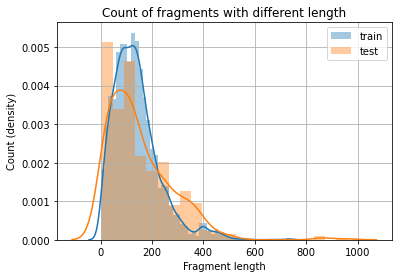

In [16]:
# Length of sequence in train data.
df_seq_label_train['seq_char_count']= df_seq_label_train['sequence'].apply(lambda x: len(x))
df_seq_label_test['seq_char_count']= df_seq_label_test['sequence'].apply(lambda x: len(x))

def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values, label=data_name)
  plt.title('Count of fragments with different length')#('Sequence char count')
  plt.xlabel('Fragment length')
  plt.ylabel('Count (density)')
  plt.grid(True)
  plt.legend()

plot_seq_count(df_seq_label_train, 'train')
plot_seq_count(df_seq_label_test, 'test')
plt.show()

Define X, y.

In [17]:
# use df_seq_label
X_train = df_seq_label_train['sequence']
#print(np.sum(X_train.isna()))  # test  #0
y_train = df_seq_label_train['class_label']

X_test = df_seq_label_test['sequence']
y_test = df_seq_label_test['class_label']

#### Data preprocessing
Transform X, y in numeric form.


In [18]:
'''
# transform label
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# muticlass prediction version
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)
'''

# transform feature(s): sequence

# concatenate data back together
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# pad/truncate sequences to a fixed length
fixed_length = 200
def pad_or_truncate_seq(seq):
    if len(seq) > fixed_length:
        seq = seq[:fixed_length]  # seq to long, truncate to fixed_length
    if len(seq) <= fixed_length:
        seq = seq.ljust(fixed_length, '-')  # seq to short, pad with '-' up to fixed_length
    return seq

train_data['sequence'] = train_data['sequence'].apply(lambda seq: pad_or_truncate_seq(seq))
#print(np.sum(X_train.isna()))  # test  #0
test_data['sequence'] = test_data['sequence'].apply(lambda seq: pad_or_truncate_seq(seq))

# separate sequence string in single letters
train_data['sequence'] = train_data['sequence'].apply(lambda seq: list(seq))  # split seq string into a list of characters
#print(np.sum(X_train.isna()))  # test  #0
test_data['sequence'] = test_data['sequence'].apply(lambda seq: list(seq))

# convert single letter to single interger
aas_2_int = {'-':0}
for index, aa in enumerate(aas):
    aas_2_int[aa] = index + 1
'''
def encode_seq_to_int(series):
    # encode amino acid sequence to integer values. All AAs occurred in data are taken into consideration. All other letters (inclusive '-') are categorized as 0.
    encoded_seq_list = []
    for seq in series.values:
        encoded_seq = []
        for aa in seq:
            encoded_seq.append(aas_2_int.get(aa, 0))
        encoded_seq_list.append(np.array(encoded_seq))
    return pd.Series(encoded_seq_list)
    #return pd.DataFrame(encoded_seq_list)

train_data['sequence'] = encode_seq_to_int(train_data['sequence'])
#print(np.sum(X_train.isna()))  # test  #0
test_data['sequence'] = encode_seq_to_int(test_data['sequence'])
'''
def encode_seq_to_int(seq):
    # encode amino acid sequence to integer values. All AAs occurred in data are taken into consideration. All other letters (inclusive '-') are categorized as 0.
    encoded_seq = []
    for aa in seq:
        encoded_seq.append(aas_2_int.get(aa, 0))
    return np.array(encoded_seq)

train_data['sequence'] = train_data['sequence'].apply(lambda seq: encode_seq_to_int(seq))
test_data['sequence'] = test_data['sequence'].apply(lambda seq: encode_seq_to_int(seq))

# separate X, y
X_train = train_data['sequence']
X_train = pd.DataFrame(X_train.to_list())
y_train = train_data['class_label']

X_test = test_data['sequence']
X_test = pd.DataFrame(X_test.to_list())
y_test = test_data['class_label']

'''
# convert single integer to one-hot encoded array
aa_int_2_one_hot_array = {}
for aa_int in aas_2_int.values():
    one_hot_list = [0 for i in range(len(aas_2_int))]
    one_hot_list[aa_int] = 1
    aa_int_2_one_hot_array[aa_int] = np.array(one_hot_list)

def encode_int_seq_to_one_hot(series):
    encoded_int_seq_list = []
    for int_seq in series.values:
        encoded_int_seq = []
        for aa_int in int_seq:
            encoded_int_seq.append(aa_int_2_one_hot_array.get(aa_int))
        encoded_int_seq_list.append(np.array(encoded_int_seq))
    return pd.Series(encoded_int_seq_list)

X_train = encode_int_seq_to_one_hot(X_train)  # shape=(7893, 200, 24)
X_test = encode_int_seq_to_one_hot(X_test)
'''

'\n# convert single integer to one-hot encoded array\naa_int_2_one_hot_array = {}\nfor aa_int in aas_2_int.values():\n    one_hot_list = [0 for i in range(len(aas_2_int))]\n    one_hot_list[aa_int] = 1\n    aa_int_2_one_hot_array[aa_int] = np.array(one_hot_list)\n\ndef encode_int_seq_to_one_hot(series):\n    encoded_int_seq_list = []\n    for int_seq in series.values:\n        encoded_int_seq = []\n        for aa_int in int_seq:\n            encoded_int_seq.append(aa_int_2_one_hot_array.get(aa_int))\n        encoded_int_seq_list.append(np.array(encoded_int_seq))\n    return pd.Series(encoded_int_seq_list)\n\nX_train = encode_int_seq_to_one_hot(X_train)  # shape=(7893, 200, 24)\nX_test = encode_int_seq_to_one_hot(X_test)\n'

Transform X, y in one-hot encoded form.

In [6]:
categories_one_col = list(aas_2_int.values())
categories = [categories_one_col for i in range(fixed_length)]

enc = OneHotEncoder(handle_unknown='error', categories=categories)
X_train = pd.DataFrame(enc.fit_transform(X_train).toarray())
X_test = pd.DataFrame(enc.fit_transform(X_test).toarray())

Perform data standardization and Principal Component Analysis. (Note: Using the stats of training set to standardize testing set, same procedure for PCA.)

In [19]:
# z-score normalization
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

# principal component analysis, explained variance 99%)
pca = PCA(n_components=0.99, random_state=0)
X_train = pd.DataFrame(pca.fit_transform(X_train))
X_test = pd.DataFrame(pca.transform(X_test))
print(f'PCA: n_components_={pca.n_components_}\n')

PCA: n_components_=192



Handle data imbalance using over-/undersampling only on training dataset. Upsampling the minority class.

In [20]:
# concatenate training data back together
X = pd.concat([X_train, y_train], axis=1)
#print(np.sum(X.isna()))  # test  #0

# determine the majority class and the number of samples in this class
print(X['class_label'].value_counts())
X['class_label'].value_counts(sort=True).plot.bar()
plt.show()

# separate different classes
X_1 = X[X.class_label == 1]
X_2 = X[X.class_label == 2]
X_3 = X[X.class_label == 3]
X_4 = X[X.class_label == 4]

# upsample other 3 classes to the majority class
X_1_up = resample(X_1, replace=True, n_samples=3944, random_state=0)
#X_1_up = X_1_up.fillna(method='ffill', axis=0)  # fill NaN gaps forwardly (use last observation)
#X_1_up = X_1_up.dropna()
X_2_up = resample(X_2, replace=True, n_samples=3944, random_state=0)
#X_2_up = X_2_up.fillna(method='ffill', axis=0)
#X_2_up = X_2_up.dropna()
X_4_up = resample(X_4, replace=True, n_samples=3944, random_state=0)
#X_4_up = X_4_up.fillna(method='ffill', axis=0)
#X_4_up = X_4_up.dropna()

X_up = pd.concat([X_1_up, X_2_up, X_3, X_4_up], axis=0)

print(X_up['class_label'].value_counts())
X_up['class_label'].value_counts().plot(kind='bar')
plt.show()

# shuffle rows in X_up and reset index afterwords
X_up = shuffle(X_up, random_state=0)
X_up = X_up.reset_index(drop=True)

# split X_up in train and test set
X_train_up = X_up.drop('class_label', axis=1)
y_train_up = X_up['class_label']

Add group label to over-sampeled data set, a sample that appears multiple times is a group.

Downsapling the majority classes.

4    154
3    154
2    154
1    154
Name: class_label, dtype: int64


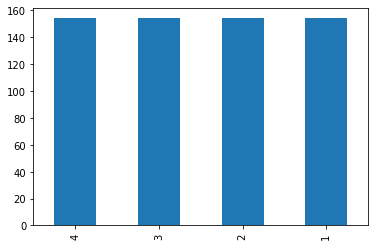

In [10]:
# downsample other 3 classes to the minority class,
X_1_down = resample(X_1, replace=False, n_samples=154, random_state=0)
X_2_down = resample(X_2, replace=False, n_samples=154, random_state=0)
X_3_down = resample(X_3, replace=False, n_samples=154, random_state=0)

X_down = pd.concat([X_1_down, X_2_down, X_3_down, X_4], axis=0)

print(X_down['class_label'].value_counts())
X_down['class_label'].value_counts().plot(kind='bar')
plt.show()

# shuffle rows in X_up and reset index afterwords
X_down = shuffle(X_down, random_state=0)
X_down = X_down.reset_index(drop=True)

# split X_up in train and test set
X_train_down = X_down.drop('class_label', axis=1)
y_train_down = X_down['class_label']

#### Baseline models
Build baseline models using Zero Rule, stratified and random algorithm.

--------------zeroR---------------
Accuracy score of baseline_zeroR model: 0.48623853211009177
AUC score: 0.5
Accuracy score of baseline_zeroR model trained on upsampled data: 0.1811926605504587
AUC score: 0.5


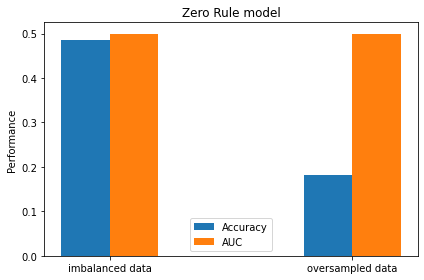

In [8]:
# zero rule algorithm for classification: predict the class value that is most common in the training dataset
'''
def zero_rule_classifier(y_train, X_test):
    train_labels = y_train.tolist()
    test_prediction = max(set(train_labels), key=train_labels.count)
    test_results = [test_prediction for i in range(len(X_test))]
    return test_results

zero_rule_pred = zero_rule_classifier(y_train, X_test)
'''
print('--------------zeroR---------------')
baseline_zeroR = DummyClassifier(strategy="most_frequent")
baseline_zeroR.fit(X_train, y_train)
#print(baseline_zeroR.predict(X_test))  # test
zeroR_acc_score = baseline_zeroR.score(X_test, y_test)  # 0.48
print(f'Accuracy score of baseline_zeroR model: {zeroR_acc_score}')
#print(classification_report(y_test, baseline_zeroR.predict(y_test)))
zeroR_auc_score = roc_auc_score(y_test, baseline_zeroR.predict_proba(X_test), average='macro', multi_class='ovo')#average='weighted', because of imbalanced data
print(f'AUC score: {zeroR_auc_score}')

# using upsampled data
baseline_zeroR.fit(X_train_up, y_train_up)
#print(baseline_zeroR.predict(X_test))  # test
zeroR_acc_score_up = baseline_zeroR.score(X_test, y_test)  # 0.18
print(f'Accuracy score of baseline_zeroR model trained on upsampled data: {zeroR_acc_score_up}')
#print(classification_report(y_test, baseline_zeroR.predict(y_test)))
zeroR_auc_score_up = roc_auc_score(y_test, baseline_zeroR.predict_proba(X_test), average='macro', multi_class='ovo')
print(f'AUC score: {zeroR_auc_score_up}')
'''
# using downsampled data
baseline_zeroR.fit(X_train_down, y_train_down)
zeroR_acc_score_down = baseline_zeroR.score(X_test, y_test)  #
print(f'Accuracy score of baseline_zeroR model trained on downsampled data: {zeroR_acc_score_down}')
#print(classification_report(y_test, baseline_zeroR.predict(y_test)))
zeroR_auc_score = roc_auc_score(y_test, baseline_zeroR.predict_proba(X_test), average='macro', multi_class='ovo')
print(f'AUC score: {zeroR_auc_score}')
'''

# plot the result
labels = ['imbalanced data', 'oversampled data']
acc_scores = [zeroR_acc_score, zeroR_acc_score_up]
auc_scores = [zeroR_auc_score, zeroR_auc_score_up]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots()
ax.bar(x - width/2, acc_scores, width, label='Accuracy')
ax.bar(x + width/2, auc_scores, width, label='AUC')
ax.set_ylabel('Performance')
ax.set_title('Zero Rule model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

--------------stratified---------------
Accuracy score of baseline_stratified model: 0.37155963302752293
AUC score: 0.5320655275249484
Accuracy score of baseline_stratified model trained on upsampled data: 0.23853211009174313
AUC score: 0.5198474873275352


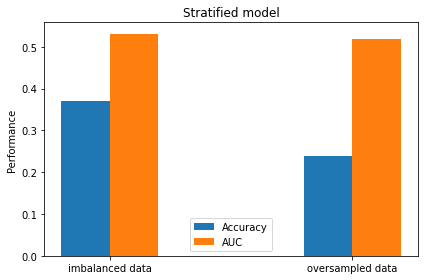

In [9]:
# “stratified”: generates predictions by respecting the training set’s class distribution.
print('--------------stratified---------------')
baseline_stratified = DummyClassifier(strategy="stratified", random_state=0)
baseline_stratified.fit(X_train, y_train)
stratified_acc_score = baseline_stratified.score(X_test, y_test)  # 0.37
print(f'Accuracy score of baseline_stratified model: {stratified_acc_score}')
#print(classification_report(y_test, baseline_stratified.predict(y_test)))
stratified_auc_score = roc_auc_score(y_test, baseline_stratified.predict_proba(X_test), average='macro', multi_class='ovo')#average='weighted', because of imbalanced data
print(f'AUC score: {stratified_auc_score}')
# using upsampled data
baseline_stratified.fit(X_train_up, y_train_up)
stratified_acc_score_up = baseline_stratified.score(X_test, y_test)  # 0.23
print(f'Accuracy score of baseline_stratified model trained on upsampled data: {stratified_acc_score_up}')
#print(classification_report(y_test, baseline_stratified.predict(y_test)))
stratified_auc_score_up = roc_auc_score(y_test, baseline_stratified.predict_proba(X_test), average='macro', multi_class='ovo')
print(f'AUC score: {stratified_auc_score_up}')
'''
# using downsampled data
baseline_stratified.fit(X_train_down, y_train_down)
stratified_acc_score_down = baseline_stratified.score(X_test, y_test)  #
print(f'Accuracy score of baseline_stratified model trained on downsampled data: {stratified_acc_score_down}')
#print(classification_report(y_test, baseline_stratified.predict(y_test)))
stratified_auc_score = roc_auc_score(y_test, baseline_stratified.predict_proba(X_test), average='macro', multi_class='ovo')
print(f'AUC score: {stratified_auc_score}')
'''

# plot the result
labels = ['imbalanced data', 'oversampled data']
acc_scores = [stratified_acc_score, stratified_acc_score_up]
auc_scores = [stratified_auc_score, stratified_auc_score_up]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots()
ax.bar(x - width/2, acc_scores, width, label='Accuracy')
ax.bar(x + width/2, auc_scores, width, label='AUC')
ax.set_ylabel('Performance')
ax.set_title('Stratified model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

--------------random---------------
Accuracy score of baseline_randm model: 0.2408256880733945
AUC score: 0.5
Accuracy score of baseline_random model trained on upsampled data: 0.2408256880733945
AUC score: 0.5


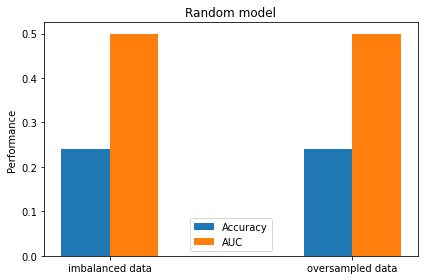

In [10]:
# “uniform”: generates predictions uniformly at random.
print('--------------random---------------')
baseline_random = DummyClassifier(strategy="uniform", random_state=0)
baseline_random.fit(X_train, y_train)
random_acc_score = baseline_random.score(X_test, y_test)  # 0.24
print(f'Accuracy score of baseline_randm model: {random_acc_score}')
#print(classification_report(y_test, baseline_random.predict(y_test)))
random_auc_score = roc_auc_score(y_test, baseline_random.predict_proba(X_test), average='macro', multi_class='ovo')#average='weighted', because of imbalanced data
print(f'AUC score: {random_auc_score}')
# using upsampled data
baseline_random.fit(X_train_up, y_train_up)
random_acc_score_up = baseline_random.score(X_test, y_test)  # 0.24
print(f'Accuracy score of baseline_random model trained on upsampled data: {random_acc_score_up}')
#print(classification_report(y_test, baseline_random.predict(y_test)))
random_auc_score_up = roc_auc_score(y_test, baseline_random.predict_proba(X_test), average='macro', multi_class='ovo')
print(f'AUC score: {random_auc_score_up}')
'''
# using downsampled data
baseline_random.fit(X_train_down, y_train_down)
random_acc_score_down = baseline_random.score(X_test, y_test)  #
print(f'Accuracy score of baseline_random model trained on downsampled data: {random_acc_score_down}')
#print(classification_report(y_test, baseline_random.predict(y_test)))
random_auc_score = roc_auc_score(y_test, baseline_random.predict_proba(X_test), average='macro', multi_class='ovo')
print(f'AUC score: {random_auc_score}')
'''

# plot the result
labels = ['imbalanced data', 'oversampled data']
acc_scores = [random_acc_score, random_acc_score_up]
auc_scores = [random_auc_score, random_auc_score_up]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots()
ax.bar(x - width/2, acc_scores, width, label='Accuracy')
ax.bar(x + width/2, auc_scores, width, label='AUC')
ax.set_ylabel('Performance')
ax.set_title('Random model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

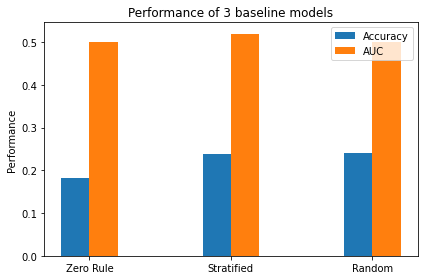

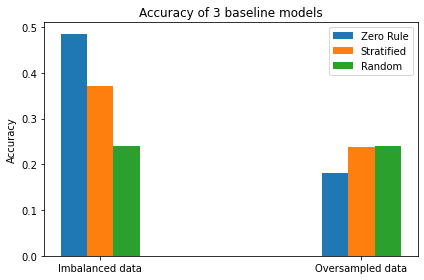

In [11]:
# plot results from 3 baselines, only use scores based on oversampled data
labels = ['Zero Rule', 'Stratified', 'Random']
acc_scores = [zeroR_acc_score_up, stratified_acc_score_up, random_acc_score_up]
auc_scores = [zeroR_auc_score_up, stratified_auc_score_up, random_auc_score_up]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots()
ax.bar(x - width/2, acc_scores, width, label='Accuracy')
ax.bar(x + width/2, auc_scores, width, label='AUC')
ax.set_ylabel('Performance')
ax.set_title('Performance of 3 baseline models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

# plot the result
labels = ['Imbalanced data', 'Oversampled data']
zeroR_acc_scores = [zeroR_acc_score, zeroR_acc_score_up]
stratified_acc_scores = [stratified_acc_score, stratified_acc_score_up]
random_acc_scores = [random_acc_score, random_acc_score_up]
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars
fig, ax = plt.subplots()
ax.bar(x - 2*(width/2), zeroR_acc_scores, width, label='Zero Rule')
ax.bar(x + 0*(width/2), stratified_acc_scores, width, label='Stratified')
ax.bar(x + 2*(width/2), random_acc_scores, width, label='Random')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of 3 baseline models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

#### Neural network
Model selection using 5-fold cross validation, inclusive hyperparameter tuning.

In [7]:
# Perform cross-validation to optimize hyperparameters
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

ann_model = MLPClassifier(activation='relu', solver='adam', max_iter=100, early_stopping=True, random_state=0, n_iter_no_change=5)

ann_params = {
    'hidden_layer_sizes': [(50, 50), (50, 50, 50), (100, 100)],
    'learning_rate_init': [0.1, 0.01, 0.001]}#,'activation':['relu', 'tanh', 'logistic']}

scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc_ovo', 'F1': 'f1_macro'}  # for balanced data
#scoring = {'Accuracy': 'balanced_accuracy', 'AUC': 'roc_auc_ovo_weighted', 'F1': 'f1_weighted'}  # if working with imbalanced data

ann_grid = GridSearchCV(estimator=ann_model, cv=cv, param_grid=ann_params, return_train_score=True, scoring=scoring, refit='AUC', verbose=3)
ann_grid.fit(X_train_up, y_train_up)
#ann_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END hidden_layer_sizes=(50, 50), learning_rate_init=0.1; AUC: (train=0.502, test=0.501) Accuracy: (train=0.500, test=0.500) F1: (train=0.173, test=0.168) total time=   6.3s
[CV 2/5] END hidden_layer_sizes=(50, 50), learning_rate_init=0.1; AUC: (train=0.504, test=0.502) Accuracy: (train=0.504, test=0.500) F1: (train=0.177, test=0.168) total time=   5.9s
[CV 3/5] END hidden_layer_sizes=(50, 50), learning_rate_init=0.1; AUC: (train=0.501, test=0.499) Accuracy: (train=0.500, test=0.500) F1: (train=0.169, test=0.168) total time=   4.7s
[CV 4/5] END hidden_layer_sizes=(50, 50), learning_rate_init=0.1; AUC: (train=0.504, test=0.500) Accuracy: (train=0.502, test=0.500) F1: (train=0.172, test=0.167) total time=   5.1s
[CV 5/5] END hidden_layer_sizes=(50, 50), learning_rate_init=0.1; AUC: (train=0.660, test=0.594) Accuracy: (train=0.607, test=0.499) F1: (train=0.336, test=0.269) total time=   7.6s
[CV 1/5] END hidden_layer_size

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=MLPClassifier(early_stopping=True, max_iter=100,
                                     n_iter_no_change=5, random_state=0),
             param_grid={'hidden_layer_sizes': [(50, 50), (50, 50, 50),
                                                (100, 100)],
                         'learning_rate_init': [0.1, 0.01, 0.001]},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc_ovo', 'Accuracy': 'accuracy',
                      'F1': 'f1_macro'},
             verbose=3)

#### Random Forest

In [36]:
# Perform cross-validation to optimize hyperparameters
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

rfc_model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=0, oob_score=True, criterion='gini')

rfc_params = {
    'n_estimators': [100, 300],
    #'max_features': ['sqrt', 'log2', None, 0.5],  # The number of features to consider when looking for the best split
    'max_depth' : [4, 8],
    #'criterion' : ['gini', 'entropy']
}

scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc_ovo', 'F1': 'f1_macro'}  # for balanced data
#scoring = {'Accuracy': 'balanced_accuracy', 'AUC': 'roc_auc_ovo_weighted', 'F1': 'f1_weighted'}  # if working with imbalanced data

rfc_grid = GridSearchCV(estimator=rfc_model, param_grid=rfc_params, cv=cv, return_train_score=True, scoring=scoring, refit='AUC', verbose=3)
rfc_grid.fit(X_train_up, y_train_up)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(max_depth=8, oob_score=True,
                                              random_state=0),
             param_grid={'max_depth': [4, 8], 'n_estimators': [100, 300]},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc_ovo', 'Accuracy': 'accuracy',
                      'F1': 'f1_macro'},
             verbose=True)

#### Suppport Vector Classification

In [9]:
# Perform cross-validation to optimize hyperparameters
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

svc_model = SVC(random_state=0, probability=True, kernel='rbf')

svc_params = {
    'C': [0.1, 1],
    'gamma': [0.001, 'scale', 'auto'],
    #'kernel': ['rbf', 'poly', 'sigmoid']
}

scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc_ovo', 'F1': 'f1_macro'}  # for balanced data
#scoring = {'Accuracy': 'balanced_accuracy', 'AUC': 'roc_auc_ovo_weighted', 'F1': 'f1_weighted'}  # if working with imbalanced data

svc_grid = GridSearchCV(estimator=svc_model, param_grid=svc_params, cv=cv, return_train_score=True, scoring=scoring, refit='AUC', verbose=3)
svc_grid.fit(X_train_up, y_train_up)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(probability=True, random_state=0),
             param_grid={'C': [0.1, 1], 'gamma': [0.001, 'scale', 'auto']},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc_ovo', 'Accuracy': 'accuracy',
                      'F1': 'f1_macro'},
             verbose=True)

#### Result analysis
Results on the training data.

In [9]:
# neural network
ann_cv_results = pd.DataFrame(ann_grid.cv_results_)
#print(ann_cv_results)
ann_best_result = ann_cv_results.loc[ann_cv_results['rank_test_AUC'] == 1]
print(ann_best_result[[
    'mean_test_Accuracy', 'std_test_Accuracy', 'mean_train_Accuracy',  'std_train_Accuracy',
    'mean_test_AUC', 'std_test_AUC', 'mean_train_AUC',  'std_train_AUC',
    'mean_test_F1', 'std_test_F1', 'mean_train_F1',  'std_train_F1']])
print()
print(ann_grid.best_params_)

   mean_test_Accuracy  std_test_Accuracy  mean_train_Accuracy  \
1            0.595592           0.009058             0.870233   

   std_train_Accuracy  mean_test_AUC  std_test_AUC  mean_train_AUC  \
1            0.038823       0.780785      0.007888        0.963303   

   std_train_AUC  mean_test_F1  std_test_F1  mean_train_F1  std_train_F1  
1       0.014742      0.522606     0.024989        0.82309      0.074441  

{'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01}


In [37]:
# random forest
rfc_cv_results = pd.DataFrame(rfc_grid.cv_results_)
#print(rfc_cv_results)
rfc_best_result = rfc_cv_results.loc[rfc_cv_results['rank_test_AUC'] == 1]
print(rfc_best_result[[
    'mean_test_Accuracy', 'std_test_Accuracy', 'mean_train_Accuracy',  'std_train_Accuracy',
    'mean_test_AUC', 'std_test_AUC', 'mean_train_AUC',  'std_train_AUC',
    'mean_test_F1', 'std_test_F1', 'mean_train_F1',  'std_train_F1']])
print()
print(rfc_grid.best_params_)

   mean_test_Accuracy  std_test_Accuracy  mean_train_Accuracy  \
3            0.797477           0.006198             0.890498   

   std_train_Accuracy  mean_test_AUC  std_test_AUC  mean_train_AUC  \
3             0.00337       0.920881      0.001195        0.962875   

   std_train_AUC  mean_test_F1  std_test_F1  mean_train_F1  std_train_F1  
3       0.001611      0.793312      0.00599       0.888679      0.003036  

{'max_depth': 8, 'n_estimators': 300}


In [8]:
# support vector
svc_cv_results = pd.DataFrame(svc_grid.cv_results_)
#print(svc_cv_results)
svc_best_result = svc_cv_results.loc[svc_cv_results['rank_test_AUC'] == 1]
print(svc_best_result[[
    'mean_test_Accuracy', 'std_test_Accuracy', 'mean_train_Accuracy',  'std_train_Accuracy',
    'mean_test_AUC', 'std_test_AUC', 'mean_train_AUC',  'std_train_AUC',
    'mean_test_F1', 'std_test_F1', 'mean_train_F1',  'std_train_F1']])
print()
print(svc_grid.best_params_)

NameError: name 'svc_grid' is not defined

#### Save or load trained models
Use joblib to save trained models under directory "trained_models", or load them from same directory.

In [15]:
# neural network
# save the model to disk
ann_filename = 'trained_models/ann_trained_model.sav'
joblib.dump(ann_grid, ann_filename)

['trained_models/ann_trained_model.sav']

In [2]:
# loading example: load the model from disk
ann_filename = 'trained_models/ann_trained_model.sav'
ann_grid = joblib.load(ann_filename)
#loaded_model = joblib.load(ann_filename)
#result = loaded_model.score(X_test, y_test)
#print(result)

In [44]:
# random forest
# save the model to disk
rfc_filename = 'trained_models/rfc_trained_model.sav'
joblib.dump(rfc_grid, rfc_filename)

['trained_models/rfc_trained_model.sav']

In [ ]:
# load model
rfc_filename = 'trained_models/rfc_trained_model.sav'
rfc_grid = joblib.load(rfc_filename)

In [11]:
# suppport vector
# save the model to disk
svc_filename = 'trained_models/svc_trained_model.sav'
joblib.dump(svc_grid, svc_filename)

['trained_models/svc_trained_model.sav']

In [ ]:
# load model
svc_filename = 'trained_models/svc_trained_model.sav'
svc_grid = joblib.load(svc_filename)

#### Performance estimation
Use best estimator and assess performance on the test set.

In [11]:
# neural network
# Calculate predictions
best_ann_model = ann_grid.best_estimator_
print(best_ann_model)

ann_y_pred = best_ann_model.predict(X_test)
ann_pred_score = best_ann_model.score(X_test, y_test)
print('Accuracy score of best_ann_model: {}'.format(round(ann_pred_score, 3)))

ann_auc_score = roc_auc_score(y_test, best_ann_model.predict_proba(X_test), average='weighted', multi_class='ovo')
print(f'AUC score: {ann_auc_score}')

ann_cl_report = classification_report(y_test, ann_y_pred)
print(ann_cl_report)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(50, 50),
              learning_rate_init=0.01, max_iter=100, n_iter_no_change=5,
              random_state=0)
Accuracy score of best_ann_model: 0.463
AUC score: 0.6441641531274744
              precision    recall  f1-score   support

           1       0.31      0.42      0.35        79
           2       0.63      0.20      0.30       137
           3       0.50      0.67      0.57       212
           4       0.00      0.00      0.00         8

    accuracy                           0.46       436
   macro avg       0.36      0.32      0.31       436
weighted avg       0.49      0.46      0.44       436



D:\Software\Anaconda\envs\CATHpre\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Software\Anaconda\envs\CATHpre\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Software\Anaconda\envs\CATHpre\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# random forest
# Calculate predictions
best_rfc_model = rfc_grid.best_estimator_
print(best_rfc_model)

rfc_y_pred = best_rfc_model.predict(X_test)
rfc_pred_score = best_rfc_model.score(X_test, y_test)
print('Accuracy score of best_rfc_model: {}'.format(round(rfc_pred_score, 3)))

rfc_auc_score = roc_auc_score(y_test, best_rfc_model.predict_proba(X_test), average='weighted', multi_class='ovo')
print(f'AUC score: {round(rfc_auc_score, 3)}')

rfc_cl_report = classification_report(y_test, rfc_y_pred)
print(rfc_cl_report)

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=None,
                       n_estimators=500, oob_score=True, random_state=0)
Accuracy score of best_rfc_model: 0.335
AUC score: 0.566
              precision    recall  f1-score   support

           1       0.20      0.18      0.19        79
           2       0.26      0.14      0.18       137
           3       0.47      0.52      0.50       212
           4       0.03      0.25      0.06         8

    accuracy                           0.33       436
   macro avg       0.24      0.27      0.23       436
weighted avg       0.35      0.33      0.33       436



In [12]:
# support vector
# Calculate predictions
best_svc_model = svc_grid.best_estimator_
print(best_svc_model)

svc_y_pred = best_svc_model.predict(X_test)
svc_pred_score = best_svc_model.score(X_test, y_test)
print('Accuracy score of best_svc_model: {}'.format(round(svc_pred_score, 3)))

svc_auc_score = roc_auc_score(y_test, best_svc_model.predict_proba(X_test), average='weighted', multi_class='ovo')
print(f'AUC score: {round(svc_auc_score, 3)}')

svc_cl_report = classification_report(y_test, svc_y_pred)
print(svc_cl_report)

SVC(C=1, probability=True, random_state=0)
Accuracy score of best_svc_model: 0.353
AUC score: 0.563
              precision    recall  f1-score   support

           1       0.23      0.30      0.26        79
           2       0.29      0.17      0.21       137
           3       0.49      0.50      0.49       212
           4       0.03      0.12      0.05         8

    accuracy                           0.35       436
   macro avg       0.26      0.27      0.25       436
weighted avg       0.37      0.35      0.35       436



Calculate and plot confusion matrix. Rows indicate true labels, columns indicate predicted labels.

[[ 33   1  45   0]
 [ 15  27  95   0]
 [ 57  13 142   0]
 [  2   2   4   0]]


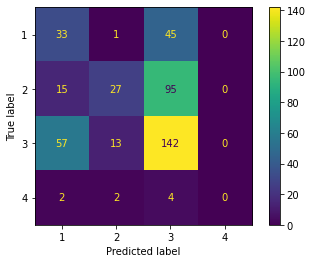

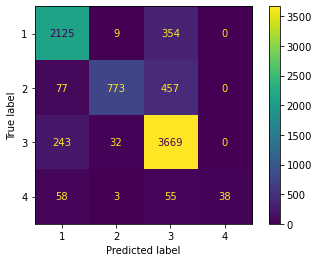

In [12]:
# neural network
# Calculate confusion matrix (showing tp, fp, tn, fn)
ann_cm = confusion_matrix(y_test, ann_y_pred)
print(ann_cm)

# plot confusion matrix
plot_confusion_matrix(best_ann_model, X_test, y_test)
plt.show()

# plot confusion matrix (on train set)
plot_confusion_matrix(best_ann_model, X_train_up, y_train_up)
#plot_confusion_matrix(best_ann_model, X_train, y_train)
plt.show()

[[ 14  13  39  13]
 [ 18  19  84  16]
 [ 35  37 111  29]
 [  2   4   0   2]]


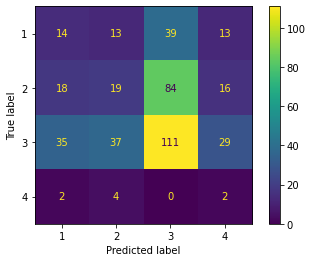

In [32]:
# random forest
# Calculate confusion matrix (showing tp, fp, tn, fn)
rfc_cm = confusion_matrix(y_test, rfc_y_pred)
print(rfc_cm)

# plot confusion matrix
plot_confusion_matrix(best_rfc_model, X_test, y_test)
plt.show()

# plot confusion matrix (on train set)
plot_confusion_matrix(best_rfc_model, X_train_up, y_train_up)
plt.show()

[[ 24  17  33   5]
 [ 25  23  79  10]
 [ 52  36 106  18]
 [  4   3   0   1]]


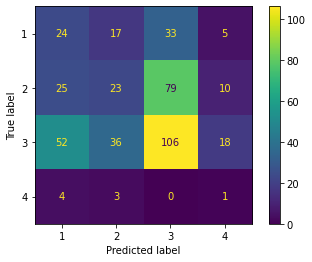

In [13]:
# support vector
# Calculate confusion matrix (showing tp, fp, tn, fn)
svc_cm = confusion_matrix(y_test, svc_y_pred)
print(svc_cm)

# plot confusion matrix
plot_confusion_matrix(best_svc_model, X_test, y_test)
plt.show()

# plot confusion matrix (on train set)
plot_confusion_matrix(best_svc_model, X_train_up, y_train_up)
plt.show()

# plot confusion matrix (on train set)
plot_confusion_matrix(best_ann_model, X_train_up, y_train_up)
plt.show()

Compute Area Under (AUC) the Receiver Operating Characteristic (ROC) Curve from prediction scores, plot ROC curve.